In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.4 MB/s eta 0:00:00


In [6]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.datasets import load_arrow_head  # Example dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Epileptic Seizure Recognition.csv to Epileptic Seizure Recognition.csv


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Data Science & AI/Projects/Epileptic Seizure Recognition (1).csv')


In [8]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [9]:
data.drop(columns=['Unnamed'], inplace=True)

In [10]:
df = data[~data['y'].isin([4, 5])]

In [11]:
X = df.drop(columns = 'y')
y = df.y

In [12]:
from sklearn.model_selection import train_test_split
# Split the data into 70% train and 30% test, with random_state=42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5520, 178), (1380, 178), (5520,), (1380,))

In [14]:
# Transform X_train needed for sktime
def from_2d_array_to_nested(
    X, index=None, columns=None, time_index=None, cells_as_numpy=False
):
    """Convert 2D dataframe to nested dataframe.

    Convert tabular pandas DataFrame with only primitives in cells into
    nested pandas DataFrame with a single column.

    Parameters
    ----------
    X : pd.DataFrame

    cells_as_numpy : bool, default = False
        If True, then nested cells contain NumPy array
        If False, then nested cells contain pandas Series

    index : array-like, shape=[n_samples], optional (default = None)
        Sample (row) index of transformed DataFrame

    time_index : array-like, shape=[n_obs], optional (default = None)
        Time series index of transformed DataFrame

    Returns
    -------
    Xt : pd.DataFrame
        Transformed DataFrame in nested format
    """
    if (time_index is not None) and cells_as_numpy:
        raise ValueError(
            "`Time_index` cannot be specified when `return_arrays` is True, "
            "time index can only be set to "
            "pandas Series"
        )
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    container = np.array if cells_as_numpy else pd.Series

    # for 2d numpy array, rows represent instances, columns represent time points
    n_instances, n_timepoints = X.shape

    if time_index is None:
        time_index = np.arange(n_timepoints)
    kwargs = {"index": time_index}

    Xt = pd.DataFrame(
        pd.Series([container(X[i, :], **kwargs) for i in range(n_instances)])
    )
    if index is not None:
        Xt.index = index
    if columns is not None:
        Xt.columns = columns
    return Xt

# Convert your X_train to nested format (if it's a 2D array where each row is a time series)
X_train_nested = from_2d_array_to_nested(X_train)



In [15]:
# Initialize ROCKET classifier
clf = RocketClassifier(num_kernels=1000,   #default=10,000
                       rocket_transform='rocket',  #inputs = [“rocket”, “minirocket”, “multirocket”]
                       max_dilations_per_kernel=32,
                       n_features_per_kernel=4,
                       use_multivariate='auto',
                       n_jobs=-1,
                       random_state=None)

In [15]:
# fit the Rocket Classifier
clf.fit(X_train_nested, y_train)

RocketClassifier(n_jobs=-1, num_kernels=1000)

In [16]:
# Generate predictions on the test set
X_test_nested = from_2d_array_to_nested(X_test)
y_pred = clf.predict(X_test_nested)

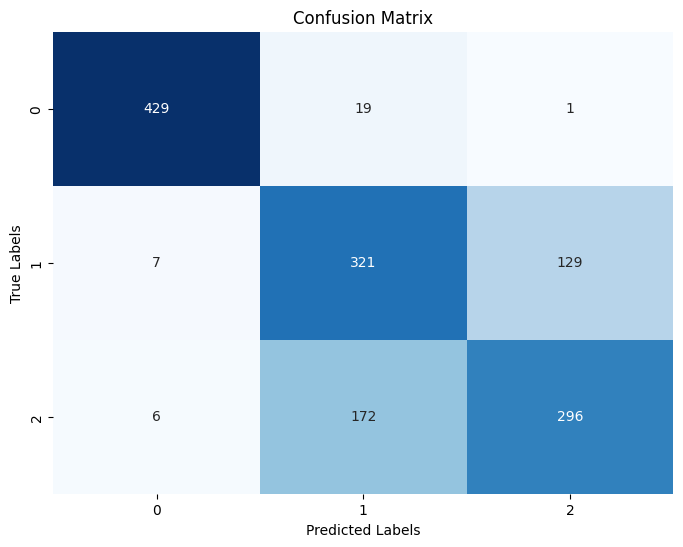

Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.96      0.96       449
           2       0.63      0.70      0.66       457
           3       0.69      0.62      0.66       474

    accuracy                           0.76      1380
   macro avg       0.76      0.76      0.76      1380
weighted avg       0.76      0.76      0.76      1380



In [17]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", class_report)

In [16]:
shapelet_class = ShapeletTransformClassifier(n_shapelet_samples=1000,
                                             max_shapelets=None, max_shapelet_length=None,
                                             estimator=None, transform_limit_in_minutes=0,
                                             time_limit_in_minutes=0,
                                             save_transformed_data=False,
                                             n_jobs=1,
                                             batch_size=100,
                                             random_state=None)

In [ ]:
# fit the Shapelet Classifier
shapelet_class.fit(X_train_nested, y_train)

In [ ]:
# Generate predictions on the test set
X_test_nested = from_2d_array_to_nested(X_test)
y_pred = shapelet_class.predict(X_test_nested)